# BIG DATA FINAL PROJECT: NOTEBOOK 1/2
# Machine Learning Pipeline - Semantic Scholar Analysis
## Nazih Kalo, Andrew Luong, Hoang Nguyen

## Reading Data from HDFS

Datasource: Semantic Scholar Open Research Corpus

Description: Semantic Scholar's records for research papers published in all fields provided as an easy-to-use JSON archive.

### Attribute Definitions
- id  string = S2 generated research paper ID.
- title  string = Research paper title.
- paperAbstract  string = Extracted abstract of the paper.
- entities  list = Extracted list of relevant entities or topics.
- s2Url  string = URL to S2 research paper details page.
- s2PdfUrl  string = URL to PDF on S2 if available.
- pdfUrls  list = URLs related to this PDF scraped from the web.
- authors  list = List of authors with an S2 generated author ID and name.
- inCitations  list = List of S2 paper IDs which cited this paper.
- outCitations  list = List of S2 paper IDs which this paper cited
- year  int = Year this paper was published as integer.
- venue  string = Extracted publication venue for this paper.
- journalName  string = Name of the journal that published this paper.
- journalVolume  string = The volume of the journal where this paper was published.
- journalPages  string = The pages of the journal where this paper was published.
- sources  list = Identifies papers sourced from DBLP or Medline.
- doi  string = Digital Object Identifier registered at doi.org.
- doiUrl  string = DOI link for registered objects.
- pmid  string = Unique identifier used by PubMed.
- fieldsOfStudy  list = Zero or more fields of study this paper addresses.`

In [1]:
#IMPORTING PACKAGES

#MATH AND DATAFRAME
import numpy as np
import pandas as pd 
import json

#VISUALIZATION
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns

#PYSPARK
from pyspark import *
from pyspark.sql import *
from pyspark.ml.linalg import *
from pyspark.ml.linalg import *
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.sql.functions import udf #user defined function
from pyspark.sql.types import * #Import types == IntegerType, StringType etc.

#NLP 
import nltk

## Setting Custom Configs for Memory

In [2]:
#import statements
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('SparkBasics').getOrCreate()
spark
#create Spark session
spark = SparkSession.builder.enableHiveSupport().appName('Final_project_read_write').getOrCreate()

conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '40g'), 
                                        ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '10'), 
                                        ('spark.cores.max', '10'), 
                                        ('spark.driver.memory','10g'),
                                        ('spark.yarn.executor.memoryOverhead', '4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.yarn.executor.memoryOverhead', '4g'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/p

### Ingestion of files from shared HDFS Repository

In [3]:
!hdfs dfs -ls /user/nazihkalo/big_data_project/unzipped_files

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 21 items
-rw-r--r--   3 nazihkalo nazihkalo 1592749572 2020-02-11 10:25 big_data_project/unzipped_files/s2-corpus-000
-rw-r--r--   3 nazihkalo nazihkalo 1592820732 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-001
-rw-r--r--   3 nazihkalo nazihkalo 1595233436 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-002
-rw-r--r--   3 nazihkalo nazihkalo 1597066383 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-003
-rw-r--r--   3 nazihkalo nazihkalo 1601510198 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-004
-rw-r--r--   3 nazihkalo nazihkalo 1593588156 2020-02-11 10:25 big_data_project/unzipped_files/s2-corpus-005
-rw-r--r--   3 nazihkalo nazihkalo 1596634329 2020-02-11 10:23 big_data_project/unzipped_files/s2-corpus-006
-rw-r--r--   3 nazihkalo nazihkalo 1596512143 2020-02-11 10:25 big_data_project/unzipped_files/s2-corpus-007
-rw-r--r-

In [4]:
sc.environment

{'MKL_NUM_THREADS': '1', 'OPENBLAS_NUM_THREADS': '1', 'PYTHONHASHSEED': '0'}

## Data Ingestion

In [3]:
spark_df = spark.read.json('big_data_project/unzipped_files/s2-corpus-000')

### Looking at the schema & summary stats

In [4]:
spark_df.printSchema()

root
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ids: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- doiUrl: string (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fieldsOfStudy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- inCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- journalName: string (nullable = true)
 |-- journalPages: string (nullable = true)
 |-- journalVolume: string (nullable = true)
 |-- outCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- paperAbstract: string (nullable = true)
 |-- pdfUrls: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pmid: string (nullable = t

In [5]:
spark_df.dtypes

[('authors', 'array<struct<ids:array<string>,name:string>>'),
 ('doi', 'string'),
 ('doiUrl', 'string'),
 ('entities', 'array<string>'),
 ('fieldsOfStudy', 'array<string>'),
 ('id', 'string'),
 ('inCitations', 'array<string>'),
 ('journalName', 'string'),
 ('journalPages', 'string'),
 ('journalVolume', 'string'),
 ('outCitations', 'array<string>'),
 ('paperAbstract', 'string'),
 ('pdfUrls', 'array<string>'),
 ('pmid', 'string'),
 ('s2PdfUrl', 'string'),
 ('s2Url', 'string'),
 ('sources', 'array<string>'),
 ('title', 'string'),
 ('venue', 'string'),
 ('year', 'bigint')]

In [6]:
spark_df.show(5)

+--------------------+--------------------+--------------------+--------+-------------------+--------------------+--------------------+-----------+------------+-------------+--------------------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------+----+
|             authors|                 doi|              doiUrl|entities|      fieldsOfStudy|                  id|         inCitations|journalName|journalPages|journalVolume|        outCitations|       paperAbstract|             pdfUrls|    pmid|s2PdfUrl|               s2Url|  sources|               title|   venue|year|
+--------------------+--------------------+--------------------+--------+-------------------+--------------------+--------------------+-----------+------------+-------------+--------------------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------+----+
|[[[52602509], Yan...|            

### Data Description

In [22]:
summary_pdf = spark_df.summary().toPandas()
summary_pdf

,summary,doi,doiUrl,id,journalName,journalPages,journalVolume,paperAbstract,pmid,s2PdfUrl,s2Url,title,venue,year
0,count,20951660,20951660,20951660,20951660,20951660,20951660,20951660,20951660,20951660,20951660,20951660,20951660,20548034
1,mean,None,None,Infinity,None,Infinity,609579.3687311141,23024.818401206638,1.5848959655556966E7,None,None,336.0,None,2002.1739107011406
2,stddev,None,None,NaN,None,NaN,3.599756476267018E8,837594.2814764327,9311305.037322745,None,None,NaN,None,15.96261332200123
3,min,,,0000050f48bc29d60f231d525700d9b15cfa4ab7,,,,,,,https://semanticscholar.org/paper/0000050f48bc...,,,1936
4,25%,None,None,Infinity,None,51.0,12.0,2.0,7707162.0,None,None,336.0,None,1995
5,50%,None,None,Infinity,None,309.0,34.0,4.0,1.5706203E7,None,None,336.0,None,2008
6,75%,None,None,Infinity,None,998.0,86.0,9.0,2.4000932E7,None,None,336.0,None,2014
7,max,10.99999/pcru_journal.v14i2.116,https://doi.org/10.99999/pcru_journal.v14i2.116,fffffcf4b3eb4b13a60e820ff15a25e2a84b1208,"“Agriculture for Life, Life for Agriculture” C...",••• - 26,xvi,􎬀 연구 배경 미용 · 건강증진을 목적으로 하는 여러 기술이 개원가를 중심으로 비급...,9999998,,https://semanticscholar.org/paper/fffffcf4b3eb...,󰡔유리동물원󰡕 톰 윙필드의 연기 양상 연구 : Michael Kirby의 〈acti...,Československá Mikrobiologie,2020


## Data Preprocessing

### Counting number of records/articles

In [4]:
initial_count = spark_df.count()
initial_count

20951660

In [5]:
#Calculating total number of NAN rows
null_row_count = initial_count - spark_df.dropna().count()
print("Total Null rows = ", null_row_count)
print("Nulls as pct of total = {}%".format((null_row_count/initial_count)*100))

Total Null rows =  403626
Nulls as pct of total = 1.9264631060259667%


### Inputation

In [91]:
#Looks like all the NAs are in year, let's impute using the median year
#Checking where the NAs are
from pyspark.sql.functions import isnan, when, count, col
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).toPandas().T

,0
authors,0
doi,0
doiUrl,0
entities,0
fieldsOfStudy,0
id,0
inCitations,0
journalName,0
journalPages,0
journalVolume,0


#### Year

In [8]:
#Impute median year
year_stats = spark_df.select('year').summary()
median_year = int(year_stats.collect()[5].year)
print('the median year is = ', median_year)

#Inputing the median year
spark_df = spark_df.na.fill({'year': median_year})

#Convert to integer type column
spark_df = spark_df.withColumn("year", spark_df["year"].cast(IntegerType()))

the median year is =  2008


In [7]:
spark_df.select(count(when(col('year').isNull(),1))).show()

+------------------------------------------+
|count(CASE WHEN (year IS NULL) THEN 1 END)|
+------------------------------------------+
|                                         0|
+------------------------------------------+



In [8]:
spark_df.select('year').distinct().count()

86

#### Fields of Sudy

In [98]:
spark_df.select('fieldsOfStudy').distinct().count()

3054

In [16]:
spark_df.groupby('fieldsOfStudy').count().sort("count").orderBy(["count"], ascending=[0]).show(20)

+-------------------+-------+
|      fieldsOfStudy|  count|
+-------------------+-------+
|         [Medicine]|1797410|
|                 []|1270796|
|        [Chemistry]| 647360|
| [Computer Science]| 605115|
|      [Engineering]| 532338|
|          [Biology]| 493352|
|          [Physics]| 456051|
|[Materials Science]| 427580|
|       [Psychology]| 354488|
|          [History]| 312121|
|        [Sociology]| 299245|
|              [Art]| 292479|
|      [Mathematics]| 269465|
|[Political Science]| 268942|
|        [Geography]| 250747|
|        [Economics]| 198698|
|[Medicine, Biology]| 189729|
|         [Business]| 184848|
|[Biology, Medicine]| 170081|
|          [Geology]| 166235|
+-------------------+-------+
only showing top 20 rows



Text(0.5,1,'Count of Papers by Field of Study')

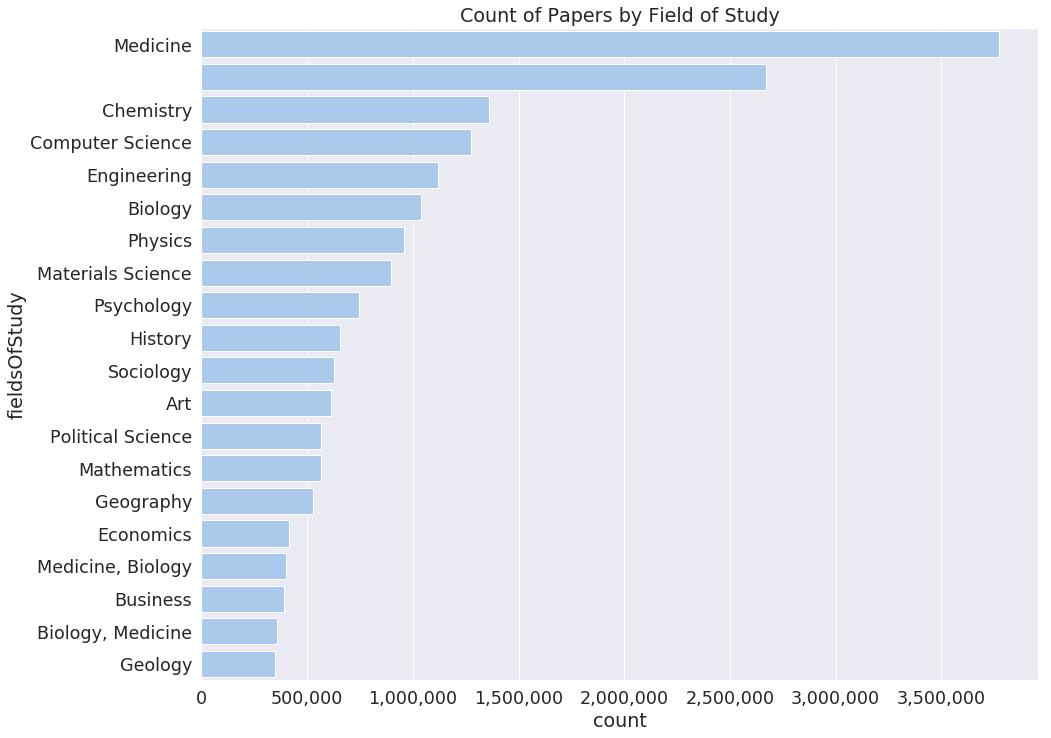

In [72]:
#Get count of articles by fieldsOfStudy
fields_count = spark_df.groupby('fieldsOfStudy').count().sort('count', ascending = False)

#convert Pyspark dataframe to Pandas dataframe for plotting
pdf = fields_count.toPandas()
pdf['fieldsOfStudy'] = pdf.fieldsOfStudy.apply(lambda x: ', '.join(x))

# Plot the total count of articles 
plt.figure(figsize = (15,12))
sns.set(font_scale=1.6)
sns.set_color_codes("pastel")
ax = sns.barplot(x="count", y="fieldsOfStudy", data=pdf[:20],
            label="Total", color="b")
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Count of Papers by Field of Study')

#### Title and Abstracts

After investigating, the majority of rows without titles and/or abstracts were determined to be non-english articles. These articles will not contribute to the business goal of determining the important linguistic features that contribute to in-citation count. Therefore we will be dropping them from our dataset.

##### Dropping those with blank abstract or title

In [10]:
spark_df2 = spark_df.filter((col('title') != '') & (col('paperAbstract') != ''))
new_count = spark_df2.count()

print('Total numbers of columns dropped = {}'.format(initial_count - new_count))
print('Percentage of columns dropped = {}%'.format(100*(initial_count - new_count)/initial_count))

Total numbers of columns dropped = 444133
Percentage of columns dropped = 44.5158199333064%


# Feature Engineering

## Dependent Variable

### Citations

Creating column that counts the inCitations = how many times this paper was cited.
This will be our dependent variable for the first part of our project scope. 

In [11]:
from pyspark.sql.functions import udf #user defined function
from pyspark.sql.types import * #Import types == IntegerType, StringType etc.

#Create UDF to count len of list
length = udf(lambda listt: len(listt), IntegerType())

#Apply UDF to count number of incitations
spark_df2 = spark_df2.withColumn('inCitations_count', length(spark_df['inCitations']))

In [12]:
#Let's look at the first few rows
spark_df2.select('inCitations_count', 'inCitations').show(10)

+-----------------+--------------------+
|inCitations_count|         inCitations|
+-----------------+--------------------+
|                0|                  []|
|                0|                  []|
|               13|[8ecaab2a03953fa5...|
|                0|                  []|
|               22|[ecec08f5ca15e07d...|
|                2|[2da3df885d1f032d...|
|                8|[ac89cd3e34dbc788...|
|                0|                  []|
|                3|[e5951f7aa9eef9c4...|
|                0|                  []|
+-----------------+--------------------+
only showing top 10 rows



Creating column that counts the outCitations = how many other papers this paper cited
Creating this column similarly to how we created the incitations column

In [13]:
spark_df2 = spark_df2.withColumn('outCitations_count', length(spark_df2['outCitations']))
spark_df2.select('outCitations_count', 'outCitations').show(10)

+------------------+--------------------+
|outCitations_count|        outCitations|
+------------------+--------------------+
|                 0|                  []|
|                 0|                  []|
|                69|[cf5cdba6424524ee...|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                66|[411f288349de96c0...|
|                12|[3dc9587f4b564c90...|
|                 0|                  []|
+------------------+--------------------+
only showing top 10 rows



In [77]:
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram

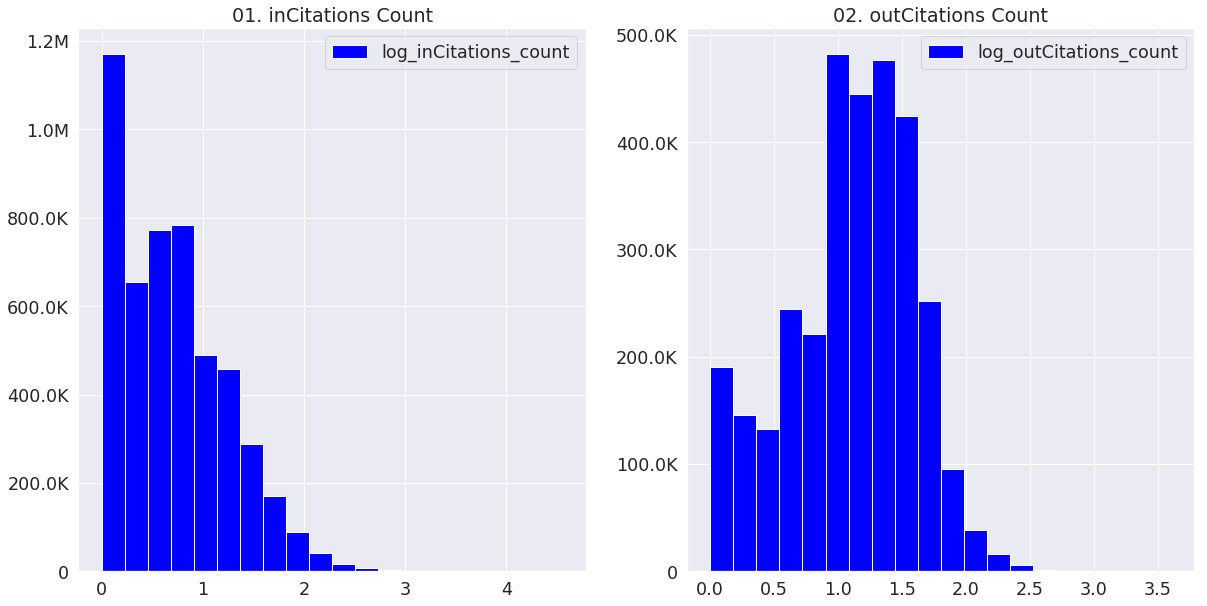

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

log_inCitations_count = spark_df2.withColumn("log_inCitations_count", log10(col("inCitations_count"))).select('log_inCitations_count')
log_outCitations_count = spark_df2.withColumn("log_outCitations_count", log10(col("outCitations_count"))).select('log_outCitations_count')

# Use the hist function to plot histograms on the Axes
hist(axes[0], [log_inCitations_count], bins = 20, color=['blue'])
axes[0].set_title('01. inCitations Count')
axes[0].legend()

hist(axes[1], [log_outCitations_count], bins = 20, color=['blue'])
axes[1].set_title('02. outCitations Count')
axes[1].legend()

## Independent Variables

Counting distinct values in each column to see which will be reasonable to keep as categorical variables (encoded)

In [11]:
from pyspark.sql.functions import countDistinct, col

distinct_pdf = spark_df2.agg(*(countDistinct(col(c)).alias(c) for c in spark_df2.columns)).collect()

distinct_pdf = pd.DataFrame(pd.DataFrame(distinct_pdf, columns = spark_df2.columns).stack(0)).rename({0:'distinct_cnt'}, axis = 1)

In [12]:
distinct_pdf.sort_values('distinct_cnt')

distinct_cnt
0 entities                       1
  s2PdfUrl                       1
  sources                        5
  year                          85
  outCitations_count           768
  inCitations_count           2007
  fieldsOfStudy               2816
  journalName                50606
  venue                      63013
  journalVolume              82485
  journalPages              583782
  pmid                     2626646
  outCitations             3150636
  pdfUrls                  3338194
  inCitations              4818096
  doiUrl                   6957101
  doi                      6957166
  authors                 10084691
  paperAbstract           11580963
  title                   11587325
  s2Url                   11625672
  id                      11625672

Let's look at a sample abstract

In [17]:
spark_df2.select('paperAbstract').limit(1).collect()[0][0]

'The problem of budgetary overrun in real estate projects has been enterprises attach great importance.In this paper,we analyze the cause of budgetary overrun in real estate projects in view of building materials,equipment investment and construction;secondly,from the construction costs of the standardized management,enterprise system management and other aspects,we super effective countermeasures to control the budgetary overrun in real estate projects;finally,taking an example of a real estate project in Hunan Province,in detail we analyze the causes and control measures of budgetary overrun in real estate projects.The study can be implemented to provide guidance for similar projects.'

### NLP Features
#### Tokenize the abstract & title

In [14]:
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer

# Clean text
spark_df2 = spark_df2.withColumn('paperAbstract', (lower(regexp_replace('paperAbstract', "[^a-zA-Z\\s]", ""))))
spark_df2 = spark_df2.withColumn('title', (lower(regexp_replace('title', "[^a-zA-Z\\s]", ""))))

# word_count = udf(lambda string: len(nltk.word_tokenize(string)), IntegerType()) ## OLD SOLUTION 
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

#tokenize words
tokenizer = Tokenizer(inputCol="paperAbstract", outputCol="abstract_tokens")
spark_df2 = tokenizer.transform(spark_df2)

tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
spark_df2 = tokenizer.transform(spark_df2)

#### Remove Stopwords

In [15]:
from pyspark.ml.feature import StopWordsRemover

#remove stop words
remover = StopWordsRemover(inputCol="abstract_tokens", outputCol="abstract_tokens_filtered")
spark_df2 = remover.transform(spark_df2)

#remove stop words
remover = StopWordsRemover(inputCol="title_tokens", outputCol="title_tokens_filtered")
spark_df2 = remover.transform(spark_df2)

#### Filter short words

In [16]:
# Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))

spark_df2 = spark_df2.withColumn('abstract_tokens_filtered', filter_length_udf(col('abstract_tokens_filtered')))
spark_df2 = spark_df2.withColumn('title_tokens_filtered', filter_length_udf(col('title_tokens_filtered')))

#### Lemmetize words

In [17]:
from nltk import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatizationFunct(x):
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem

lemmetize_udf = udf(lambda tokens: lemmatizationFunct(tokens), ArrayType(StringType())) 

spark_df2 = spark_df2.withColumn('abstract_tokens_filtered_lem', lemmetize_udf(spark_df2['abstract_tokens_filtered']))
spark_df2 = spark_df2.withColumn('title_tokens_filtered_lem', lemmetize_udf(spark_df2['title_tokens_filtered']))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/nazihkalo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Create wcount columns

In [18]:
from pyspark.sql.functions import udf 

word_count = udf(lambda tokens: len(tokens), IntegerType()) 

spark_df2 = spark_df2.withColumn('abstract_wcount', word_count(spark_df2['abstract_tokens_filtered_lem']))
spark_df2 = spark_df2.withColumn('title_wcount', word_count(spark_df2['title_tokens_filtered_lem']))

spark_df2.select('title_tokens_filtered_lem', 'title_wcount', 'abstract_tokens_filtered_lem', 'abstract_wcount').show(10)

+-------------------------+------------+----------------------------+---------------+
|title_tokens_filtered_lem|title_wcount|abstract_tokens_filtered_lem|abstract_wcount|
+-------------------------+------------+----------------------------+---------------+
|     [cause, analysis,...|           9|        [problem, budgeta...|             61|
|     [unexpected, deat...|          10|        [aim, objective, ...|            197|
|     [rnaseq, analysis...|          10|        [mitogenactivated...|            140|
|     [constituio, lxic...|           5|        [lexico, desperta...|             90|
|     [nanobiocomposite...|           8|        [ternary, nanobio...|             81|
|     [feasibility, two...|           9|        [background, aim,...|            127|
|     [prevalence, risk...|           8|        [introduction, ce...|            139|
|     [journal, vol, sa...|           3|                          []|              0|
|     [treatment, laryn...|           4|        [backg

#### NLP Cleaning - Title/Abstract Redudancy

Dropping more rows with no title/abstract that got through first filtering

In [19]:
spark_df2 = spark_df2.filter((col('title_wcount') != 0) & (col('abstract_wcount') != 0))

In [20]:
new_count2 = spark_df2.count()
print('Additional columns dropped = {}'.format(new_count - new_count2))
#print('Percentage of columns dropped = {}%'.format(100*(new_count - new_count2)/new_count))

Additional columns dropped = 15791


In [21]:
# Let's make sure there are no more title or abstract rows that are blank
spark_df2.filter((col('title_wcount') == 0) | (col('abstract_wcount') == 0)).count()

0

### TFIDF Features

#### TFIDF for abstract and title

In [22]:
#Maps a sequence of terms to their term frequencies using the hashing trick. 
hashingTF1 = HashingTF(inputCol="abstract_tokens_filtered_lem", outputCol="abstract_tokens_filtered_lem_count", numFeatures=100)
hashingTF2 = HashingTF(inputCol="title_tokens_filtered_lem", outputCol="title_tokens_filtered_lem_count", numFeatures=100)
featurizedData = hashingTF1.transform(spark_df2)
featurizedData = hashingTF2.transform(featurizedData)

#Getting IDF
idf = IDF(inputCol="abstract_tokens_filtered_lem_count", outputCol="abstract_tfidf")
idf2 = IDF(inputCol="title_tokens_filtered_lem_count", outputCol="title_tfidf")

idfModel = idf.fit(featurizedData)
spark_df3 = idfModel.transform(featurizedData)
idfModel = idf2.fit(spark_df3)
spark_df3 = idfModel.transform(spark_df3)


In [23]:
spark_df3.select('title_tokens_filtered_lem',"title_tfidf",'abstract_tokens_filtered_lem', "abstract_tfidf").show(5)

+-------------------------+--------------------+----------------------------+--------------------+
|title_tokens_filtered_lem|         title_tfidf|abstract_tokens_filtered_lem|      abstract_tfidf|
+-------------------------+--------------------+----------------------------+--------------------+
|     [cause, analysis,...|(100,[18,33,52,56...|        [problem, budgeta...|(100,[0,1,9,10,11...|
|     [unexpected, deat...|(100,[45,47,52,74...|        [aim, objective, ...|(100,[3,4,5,6,7,9...|
|     [rnaseq, analysis...|(100,[0,10,15,56,...|        [mitogenactivated...|(100,[0,4,6,8,9,1...|
|     [constituio, lxic...|(100,[21,60,65,76...|        [lexico, desperta...|(100,[1,2,3,4,6,7...|
|     [nanobiocomposite...|(100,[3,16,34,39,...|        [ternary, nanobio...|(100,[0,1,3,4,5,7...|
+-------------------------+--------------------+----------------------------+--------------------+
only showing top 5 rows



### Word2Vec Features

#### Training Model

The commented code below was used to train the Word2Vec Embeddings. We now load the model from HDFS


In [141]:
# import datetime
# # Learn a mapping from words to Vectors
# timestart = datetime.datetime.now()

# from pyspark.ml.feature import Word2Vec
# word2Vec = Word2Vec(windowSize = 5, vectorSize=50, minCount=500, \
#                     numPartitions=10, inputCol="title_tokens_filtered_lem", outputCol="title_wordVectors")
# w2VM = word2Vec.fit(spark_df3)
# nlpdf = w2VM.transform(spark_df3)

# # PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
# timeend = datetime.datetime.now()
# timedelta = (timeend - timestart).total_seconds() / 60
# print("model.getVectors().count() = {}".format(w2VM.getVectors().count()))
# print("Time taken to train the word2Vec model: " + str(timedelta) + " mins")

model.getVectors().count() = 16363
Time taken to train the word2Vec model: 4.811893800000001 mins


In [24]:
from pyspark.ml.feature import Word2Vec, Word2VecModel

#w2VM.save('word2vec_model_v50_min500_ws5_2.0')
w2VM = Word2VecModel.load("word2vec_model_v50_min500_ws5_2.0")
nlpdf = w2VM.transform(spark_df3)

In [25]:
#Inspecting the mean vector for titles 
w2v_pdf = nlpdf.select('title_tokens_filtered_lem','title_wordVectors').limit(5).toPandas()
w2v_pdf.head()

,title_tokens_filtered_lem,title_wordVectors
0,"[cause, analysis, control, measure, budgetary,...","[1.4479601118299696, -0.6119445198112063, -0.8..."
1,"[unexpected, death, medical, ward, night, shif...","[2.387523424625397, -0.6723115488886834, -1.00..."
2,"[rnaseq, analysis, reveals, mapkkk, family, me...","[0.5778246715664864, -0.42337707430124283, -1...."
3,"[constituio, lxico, como, objeto, conhecimento]","[-2.0366072177886965, -4.672249698638916, -2.4..."
4,"[nanobiocomposite, film, modified, cellulose, ...","[-3.1380852311849594, -1.6064074486494064, -0...."


#### Training Model Sample

Here is a sample 50-length mean vector of the title of an article. 

In [31]:
print('words = \n', w2v_pdf.iloc[0,0])
print('\nwordvector = \n', w2v_pdf.iloc[0,1])

words = 
 ['cause', 'analysis', 'control', 'measure', 'budgetary', 'overrun', 'contemporary', 'estate', 'project']

wordvector = 
 [1.4479601118299696,-0.6119445198112063,-0.8019161224365234,-0.27692221601804096,-0.1257759200202094,-0.4407366977797614,-0.15517845418718126,-0.4255139562818739,1.211148699124654,0.03543872965706719,0.9635194076432122,-1.0128507647249434,-1.4334388938215044,-1.3238786458969116,0.5256303482585483,-0.3156167583333121,0.7954675952593485,-1.5117583076159158,-0.4999648829301198,0.5329374737209743,-0.3384311000506083,-1.0729623900519476,0.8636661436822679,-1.0142832862006292,-1.7741386459933386,0.453844901588228,-0.7497658001052009,0.5245194534460703,-0.8809583799706564,0.5557667596472634,0.7542736132939656,0.9988466368781195,0.14865792998009256,0.21024561590618557,0.7474900152948167,0.6591735002067354,1.1465216477711995,0.4958844905098279,0.5902485383881463,1.6388408541679382,0.4554235314329465,-0.9215682347615559,0.7021893279420005,-0.1712197826968299,1.439239

In [51]:
# Let's see how useful our wordvectors seem
w2VM.findSynonymsArray('neural', 10)

[('spiking', 0.8338825106620789),
 ('convolutional', 0.8299897313117981),
 ('rbf', 0.7949727177619934),
 ('artificial', 0.7792593240737915),
 ('adversarial', 0.7513853311538696),
 ('network', 0.7242907881736755),
 ('backpropagation', 0.7111539244651794),
 ('generative', 0.7054539918899536),
 ('unsupervised', 0.7009112238883972),
 ('clustered', 0.7007094621658325)]

In [47]:
# Let's see how useful our wordvectors seem
w2VM.findSynonymsArray('dataset', 10)

[('datasets', 0.9359949827194214),
 ('data', 0.8710565567016602),
 ('informative', 0.8687659502029419),
 ('visualizing', 0.8629266619682312),
 ('classifying', 0.8611568808555603),
 ('timeseries', 0.8604452013969421),
 ('grouping', 0.8559793829917908),
 ('scene', 0.8498888611793518),
 ('geospatial', 0.8491258025169373),
 ('outlier', 0.8456076383590698)]

In [49]:
# Let's see how useful our wordvectors seem
w2VM.findSynonymsArray('hadoop', 10)

[('mapreduce', 0.974606454372406),
 ('privacypreserving', 0.9414143562316895),
 ('querying', 0.9357867240905762),
 ('encrypted', 0.9334874153137207),
 ('scalability', 0.9307804703712463),
 ('multisource', 0.9288651943206787),
 ('virtualization', 0.9231449365615845),
 ('secured', 0.9222572445869446),
 ('cloudbased', 0.9167419075965881),
 ('runtime', 0.914556622505188)]

In [50]:
# Let's see how useful our wordvectors seem
w2VM.findSynonymsArray('google', 10)

[('wikipedia', 0.8736162781715393),
 ('script', 0.8586183190345764),
 ('website', 0.8542793393135071),
 ('fake', 0.853056788444519),
 ('comic', 0.8464636206626892),
 ('text', 0.8435144424438477),
 ('tutorial', 0.841810405254364),
 ('blog', 0.8380142450332642),
 ('download', 0.8373917937278748),
 ('storytelling', 0.837169885635376)]

In [52]:
test_terms = w2VM.getVectors().filter((col('word') == 'incident') | (col('word') == 'event')).collect()
#w2VM.getVectors().first().vector

### Cosine similarity

In [22]:
#Defining cosine similarity
def cos_sim(a,b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

cos_sim_udf = udf(lambda x, y: cos_sim(x,y), FloatType())

In [54]:
# 'word' == 'incident' vs. 'word' == 'event'
cos_sim(test_terms[0].vector, test_terms[1].vector)

0.7791460489101493

In [55]:
#Get vector to test function - word = 'incident
static_array = test_terms[0].vector

w2VM.getVectors().withColumn("coSim", cos_sim_udf(col("vector"), array([lit(v) for v in static_array])))\
.orderBy('coSim',ascending = False).show()

+---------------+--------------------+----------+
|           word|              vector|     coSim|
+---------------+--------------------+----------+
|       incident|[4.10470581054687...|       1.0|
|          event|[3.38791322708129...| 0.7791461|
|       baseline|[2.28983116149902...|0.76486516|
|      nighttime|[2.24039840698242...| 0.7590682|
|      scheduled|[2.48162221908569...|0.74806994|
|   catastrophic|[2.54120850563049...|0.73826915|
|   middleincome|[2.09555363655090...|0.73688227|
|    readmission|[3.64466047286987...| 0.7310987|
|     cumulative|[2.80456018447875...|0.72757304|
|        frailty|[2.11534881591796...| 0.7086258|
|      admission|[4.05039501190185...| 0.7079517|
|   longitudinal|[2.96342611312866...|  0.706186|
|hospitalization|[3.29267930984497...|0.70490754|
|           risk|[2.72194433212280...| 0.6985625|
|       casualty|[2.74219799041748...| 0.6973717|
|       medicare|[4.32150650024414...| 0.6966048|
|       allcause|[1.78290641307830...| 0.6945771|


#### Cosine Similarity Example

Let's look for titles that are most similar to a specific word/keyword

In [56]:
nlpdf.select('title_tokens_filtered_lem','title_wordVectors')\
    .withColumn("coSim", cos_sim_udf(col("title_wordVectors"), array([lit(v) for v in static_array])))\
    .dropna()\
    .orderBy('coSim',ascending = False).show()

+-------------------------+--------------------+----------+
|title_tokens_filtered_lem|   title_wordVectors|     coSim|
+-------------------------+--------------------+----------+
|     [bushranging, inc...|[1.36823527018229...|       1.0|
|     [ripon, incident,...|[1.36823527018229...|       1.0|
|     [incident, bmbouras]|[2.05235290527343...|       1.0|
|        [incident, lorne]|[2.05235290527343...|       1.0|
|     [pickering, losso...|[1.36823527018229...|       1.0|
|        [incident, vichy]|[2.05235290527343...|       1.0|
|     [incident, freman...|[2.05235290527343...|       1.0|
|     [fastneutrons, in...|[1.36823527018229...|       1.0|
|     [odpovdnost, uiva...|[0.82094116210937...|       1.0|
|     [predicting, inci...|[2.36111958821614...|0.89912504|
|     [criterion, suici...|[2.06122986475626...|0.89121574|
|     [critical, incide...|[2.03494612375895...|  0.890937|
|     [incident, report...|[2.55328241984049...|0.88356864|
|     [considers, loggi...|[2.4205341637

### NLP Features Functions

Creating function that takes query string as input and returns similar article titles.
String should be a list of words that are relevant to your query/search

In [23]:
def search_articles(query_string, model, n = 5):
    """Uses word embeddings trained on the corpus of research papers to find titles 
    that are similar to a given search query. Provides URL for reference.
    
    Parameters:
    query_string (string): Description of arg1
    model (object) : pyspark Word2Vec Model instance
    n (int) : number of titles/articles to return

    Returns:
    DataFrame: Dataframe with the 'n' most similar titles to the given search query. Returns link to article.
    """
    
    #Put string into DF because spark W2V model only accepts a DF
    documentDF = spark.createDataFrame([(query_string.split(" "),)], ["title_tokens_filtered_lem"])
    #Get the mean vector of the query
    qry = model.transform(documentDF).collect()[0].title_wordVectors
    #Get the n most similar titles based on cosim vector distnace
    sim_titles = nlpdf.select('title','fieldsOfStudy', 'title_wordVectors', 's2Url')\
    .withColumn("coSim", cos_sim_udf(col("title_wordVectors"), array([lit(v) for v in qry])))\
    .dropna()\
    .orderBy('coSim',ascending = False).limit(n).toPandas()
    
    return sim_titles

In [28]:
search_query = input("Enter the relevant terms you are looking for:")
n_return = int(input("Enter how many titles you would like returned:"))

search_articles(query_string = search_query, 
                model = w2VM, n = n_return) 

Enter the relevant terms you are looking for:vector word embedding
Enter how many titles you would like returned:5


,title,fieldsOfStudy,title_wordVectors,s2Url,coSim
0,nondistributional word vector representations,[Computer Science],"[1.5886874198913574, -1.4757964760065079, -0.06339207291603088, -0.6495361253619194, -1.48530003...",https://semanticscholar.org/paper/e09beb33880425e5439fe076da4be7a6916df460,0.980983
1,realvalued syntactic word vectors,[Computer Science],"[1.1661015152931213, -1.4114795476198196, -0.262157179415226, -0.794933907687664, -1.25109498202...",https://semanticscholar.org/paper/0be35255c4329a48782ab101b7df81a2b7d0728f,0.971088
2,wordbits quantized word vectors,[Computer Science],"[1.8400118947029114, -0.9229391440749168, 0.06509071588516235, -0.28162211924791336, -1.26573346...",https://semanticscholar.org/paper/a74eacdd133918f82b953fc8dcd615ddca7efdfa,0.967760
3,supervised paragraph vector distributed representations of words documents and class labels,[Computer Science],"[1.7911506328317852, -0.595729755030738, -0.06709327962663439, -0.4530228575070699, -0.885006391...",https://semanticscholar.org/paper/dcdb981f11a0ddbb5e2e7392521965e3e71d0c39,0.965069
4,encoding words into string vectors for word categorization,[Computer Science],"[1.8512784540653229, -1.6727595527966816, -0.10868787517150243, -0.874036523203055, -1.279246702...",https://semanticscholar.org/paper/7aadbca355902496376e92752a8ffb66d38b01d9,0.965044


In [30]:
pd.set_option('max_colwidth', 100)
#Let's test out the function
results_pdf = search_articles(query_string = "neural network hadoop", model = w2VM, n =5)
results_pdf

,title,fieldsOfStudy,title_wordVectors,s2Url,coSim
0,crossmedia hashing with neural networks,[Computer Science],"[2.1895049810409546, 0.3853525444865227, -0.5056682452559471, -0.12536711245775223, -0.849391877...",https://semanticscholar.org/paper/b5fe4731ff6a7a7f1ad8232186e84b1f944162e0,0.990144
1,selforganizing neural networks,[Computer Science],"[2.9634455839792886, 0.5228483875592549, -0.737404907743136, 0.15041999022165933, -1.28611646095...",https://semanticscholar.org/paper/a6ea2b1cbf69ee005b23f5bf1092be8ba684dda3,0.989763
2,data aggregation using neural network in wsn sing neural network in wsn sing neural network in w...,[Engineering],"[2.6220287945535445, 0.8723543286323547, -0.8760132657157049, -0.0028696780403455096, -0.6602880...",https://semanticscholar.org/paper/623a4d00878abfa680db8a069070a91775f85cce,0.989691
3,c y d ec c po c licksequenceaware dee p neural network dnn based,[],"[1.3850777745246887, 0.4453526437282562, -0.4304767350355784, -0.044539118806521096, -0.43618155...",https://semanticscholar.org/paper/dc388059590fd63cc12295abce856d365febd7e1,0.987541
4,mp steganalysis based on neural networks,[],"[2.077616661787033, 0.6680289655923843, -0.6457151025533676, -0.06680867820978165, -0.6542723327...",https://semanticscholar.org/paper/89a706a40d02b0fb520872eb235e8a38624105f6,0.987541


In [24]:
pd.set_option('max_colwidth', 100)
#Let's test out the function
results_pdf = search_articles(query_string = "surgery heart chest", model = w2VM, n =5)
results_pdf

,title,fieldsOfStudy,title_wordVectors,s2Url,coSim
0,the heart in trauma surgery,[Medicine],"[1.5268399516741433, -1.4051317373911538, -3.426393508911133, -0.8856724202632904, -1.1310723076...",https://semanticscholar.org/paper/ac2760ba8bb170729f089b8e999ff4407e550aa2,0.980482
1,abdominal complications after heart surgery,[Medicine],"[1.2948544472455978, -0.8977705985307693, -3.6044254302978516, -0.6642236970365047, -1.618820756...",https://semanticscholar.org/paper/45186fe56c5ffd1a69c874a7177a873f62c341a2,0.977196
2,abdominal complications of heart surgery,[Medicine],"[1.2948544472455978, -0.8977705985307693, -3.6044254302978516, -0.6642236970365047, -1.618820756...",https://semanticscholar.org/paper/04f5f3eb4c63afe60c8f2592f8833e1af0b4d34a,0.977196
3,surgical correction of multivalvular defects in patients who had earlier undergone heart surgery,[Medicine],"[1.5213980376720428, -0.4742577647169431, -1.8778350444303618, -0.7537236445479922, -0.663172966...",https://semanticscholar.org/paper/99bfc4901f4a8df115694beb8dc1f8f690914a88,0.976618
4,chest gossypiboma after coronary surgery,[Medicine],"[1.76644828915596, -0.7848338391631842, -2.200995296239853, 0.1961185336112976, -1.6492455564439...",https://semanticscholar.org/paper/e9ae0ad51792adb0ee9c592246a31d46e5069c85,0.976515


In [25]:
pd.set_option('max_colwidth', 100)
#Let's test out the function
results_pdf = search_articles(query_string = "vector word language", model = w2VM, n =5)
results_pdf

,title,fieldsOfStudy,title_wordVectors,s2Url,coSim
0,parsing morphologically rich languages with mostly offtheshelf software and word vectors,[Computer Science],"[0.4211726420455508, -0.7609059280819362, -0.15865609380933973, -0.5252460042635599, -0.78695910...",https://semanticscholar.org/paper/03deaee586d61bbafb34fa7aba87dddd07050e2f,0.957930
1,are the grammatical sentences of a language a recursive set,[Computer Science],"[1.746489715576172, -0.9266925275325776, 0.06561576128005982, -1.1050312936306, -1.1029182851314...",https://semanticscholar.org/paper/0e3fb69bf3fe7d9c68c928a54d98916020edcc74,0.956906
2,bilingual word embeddings for phrasebased machine translation,[Computer Science],"[0.9805573796232541, -0.8996185561021168, 0.5172649870316187, -0.6948998967806498, -0.7572133690...",https://semanticscholar.org/paper/0d3233d858660aff451a6c2561a05378ed09725a,0.956366
3,permutations of contextfree etl and indexed languages,"[Computer Science, Mathematics]","[0.8165256261825562, -0.5742671251296997, -0.07130123972892762, -0.5454598590731621, -0.49772427...",https://semanticscholar.org/paper/45f1fe9d8159c9b15868ecdbc72cf61272d2f26a,0.953800
4,the set of minimal words of a contextfree language is contextfree,"[Mathematics, Computer Science]","[1.1505239804585774, -0.7077752687036991, -0.1750679761171341, -0.6008188699682553, -0.901705955...",https://semanticscholar.org/paper/be7967e0ba1af1df21251f6c6f58a02fcd98ed41,0.951448


## External Data Integration

### Mapping SJR

In [26]:
journal_map = spark.read.csv('big_data_project/scimagojr_2017.csv', sep = ';',inferSchema=True, header=True )

In [27]:
journal_map.printSchema()

root
 |-- Rank: integer (nullable = true)
 |-- Sourceid: long (nullable = true)
 |-- Title: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Issn: string (nullable = true)
 |-- SJR: string (nullable = true)
 |-- SJR Best Quartile: string (nullable = true)
 |-- H index: string (nullable = true)
 |-- Total Docs. (2017): integer (nullable = true)
 |-- Total Docs. (3years): integer (nullable = true)
 |-- Total Refs.: integer (nullable = true)
 |-- Total Cites (3years): integer (nullable = true)
 |-- Citable Docs. (3years): integer (nullable = true)
 |-- Cites / Doc. (2years): string (nullable = true)
 |-- Ref. / Doc.: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Coverage: string (nullable = true)
 |-- Categories: string (nullable = true)



In [28]:
#Renaming column so they dont have same name 
journal_map2 = journal_map.withColumnRenamed('Title', 'journal_name')

In [60]:
journal_map2.limit(50).toPandas()

,Rank,Sourceid,journal_name,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2017),Total Docs. (3years),Total Refs.,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Publisher,Coverage,Categories
0,1,28773,CA - A Cancer Journal for Clinicians,journal,"15424863, 00079235","61,786",Q1,144,43,130,3160,17496,109,"206,80","73,49",United States,Wiley-Blackwell,1950-ongoing,Hematology (Q1); Oncology (Q1)
1,2,18991,Nature Reviews Genetics,journal,"14710056, 14710064","34,896",Q1,320,108,430,7108,7677,168,"40,83","65,81",United Kingdom,Nature Publishing Group,2000-ongoing,Genetics (Q1); Genetics (clinical) (Q1); Molec...
2,3,19434,MMWR. Recommendations and reports : Morbidity ...,journal,"10575987, 15458601","34,638",Q1,134,2,16,184,1073,16,"82,10","92,00",United States,Centers for Disease Control and Prevention (CDC),1990-ongoing,Epidemiology (Q1); Health Information Manageme...
3,4,58530,National vital statistics reports : from the C...,journal,"15518922, 15518930","33,557",Q1,89,6,33,207,1183,33,"40,65","34,50",United States,US Department of Health and Human Services,1998-ongoing,Life-span and Life-course Studies (Q1)
4,5,20315,Nature Reviews Molecular Cell Biology,journal,"14710072, 14710080","32,714",Q1,386,112,429,7986,9042,206,"30,69","71,30",United Kingdom,Nature Publishing Group,2000-ongoing,Cell Biology (Q1); Molecular Biology (Q1)
5,6,29431,Quarterly Journal of Economics,journal,"00335533, 15314650","29,602",Q1,228,43,121,2210,1366,120,"8,90","51,40",United Kingdom,Oxford University Press,"1973-1974, 1976-ongoing",Economics and Econometrics (Q1)
6,7,21318,Nature Reviews Immunology,journal,14741733,"28,786",Q1,351,141,462,8241,8193,185,"40,50","58,45",United Kingdom,Nature Publishing Group,2001-ongoing,Immunology (Q1); Medicine (miscellaneous) (Q1)
7,8,21100812243,Nature Reviews Materials,journal,20588437,"28,630",Q1,61,91,104,7110,2823,58,"48,67","78,13",United Kingdom,Nature Publishing Group,2016-ongoing,"Biomaterials (Q1); Electronic, Optical and Mag..."
8,9,18434,Cell,journal,"00928674, 10974172","25,137",Q1,705,547,1980,27123,44674,1716,"24,83","49,59",United States,Cell Press,1974-ongoing,"Biochemistry, Genetics and Molecular Biology (..."
9,10,19700180594,Handbook of International Economics,book series,15734404,"25,020",Q1,10,0,15,0,186,0,"0,00","0,00",Netherlands,North-Holland Publ Co,"1984-1985, 1995, 2014-2015","Economics and Econometrics (Q1); Economics, Ec..."


In [29]:
journal_map2.select('journal_name').distinct().count()

33587

In [30]:
#Reduce to only relevant columns
journal_map2 = journal_map2.select('journal_name', 'SJR')

In [31]:
joined_dfs = nlpdf.join(journal_map2, on = nlpdf.journalName == journal_map2.journal_name, how = 'left_outer')

In [41]:
joined_dfs.filter(~col('SJR').isNull()).select('journalName', 'venue', 'journal_name', 'SJR').show(5)

+--------------------+--------------------+--------------------+-----+
|         journalName|               venue|        journal_name|  SJR|
+--------------------+--------------------+--------------------+-----+
|  Acta Haematologica|  Acta Haematologica|  Acta Haematologica|0,575|
|Journal of Applie...|                    |Journal of Applie...|0,646|
|IEEE Journal on E...|IEEE Journal on E...|IEEE Journal on E...|0,619|
|Journal of Clinic...|Journal of clinic...|Journal of Clinic...|0,722|
|             Synapse|             Synapse|             Synapse|0,969|
+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [42]:
joined_dfs.withColumn('SJR2', (regexp_replace('SJR', ",", ".")).cast(FloatType())).select('SJR', 'SJR2').describe().show()
#joined_dfs.withColumn('SJR2', (regexp_replace('SJR', ".", "")).cast(FloatType())).select('SJR', 'SJR2').describe().show()

+-------+-------+------------------+
|summary|    SJR|              SJR2|
+-------+-------+------------------+
|  count|1094906|           1094906|
|   mean|   null|2.2636443939976623|
| stddev|   null| 4.029927860053585|
|    min|  0,100|               0.1|
|    max|  9,791|            34.896|
+-------+-------+------------------+



In [32]:
joined_dfs = joined_dfs.withColumn('SJR', (regexp_replace('SJR', ",", ".")).cast(FloatType()))

### Null Imputation

Find percentile to fill 

In [33]:
print('Before imputation : \n')
joined_dfs.select('SJR').summary().show()

joined_dfs = joined_dfs.na.fill({'SJR': 0.474})

print('After imputation : \n')
joined_dfs.select('SJR').summary().show()

Before imputation : 

+-------+------------------+
|summary|               SJR|
+-------+------------------+
|  count|             52112|
|   mean|2.2736829872057815|
| stddev| 4.040847356202027|
|    min|               0.1|
|    25%|             0.472|
|    50%|             0.956|
|    75%|             1.737|
|    max|            34.896|
+-------+------------------+

After imputation : 

+-------+------------------+
|summary|               SJR|
+-------+------------------+
|  count|            538035|
|   mean|0.6483103760703426|
| stddev| 1.365577901261689|
|    min|               0.1|
|    25%|             0.474|
|    50%|             0.474|
|    75%|             0.474|
|    max|            34.896|
+-------+------------------+



## Data Type Issues


### Splitting authors column into authorname & authorID

In [34]:
import pyspark.sql.functions as F
joined_dfs = joined_dfs.withColumn('author_ids', F.col('authors.ids'))
joined_dfs = joined_dfs.withColumn('author_names', F.col('authors.name'))

### Counting number of authors 

In [35]:
joined_dfs = joined_dfs.withColumn('author_count', word_count(joined_dfs['author_names']))

joined_dfs.select('author_names' ,'author_count').show(5)

+--------------------+------------+
|        author_names|author_count|
+--------------------+------------+
|       [Yang Li-pin]|           1|
|[Mns Rn Community...|           2|
|[Ya Jun Liu, Miao...|           8|
|[Maria Auxiliador...|           1|
|[Elena Fortunati,...|           9|
+--------------------+------------+
only showing top 5 rows



## One Hot Encoding

In [39]:
joined_dfs.select('fieldsOfStudy', 'sources').show(5)

+--------------------+---------+
|       fieldsOfStudy|  sources|
+--------------------+---------+
|          [Business]|       []|
|          [Medicine]|       []|
| [Medicine, Biology]|[Medline]|
|        [Philosophy]|       []|
|[Medicine, Chemis...|[Medline]|
+--------------------+---------+
only showing top 5 rows



In [49]:
joined_dfs.select('sources').distinct().show()

+---------------+
|        sources|
+---------------+
|      [Medline]|
|         [DBLP]|
|             []|
|[Medline, DBLP]|
|[DBLP, Medline]|
+---------------+



### String Creation

Unpack the arrays to creat strings

In [36]:
#Defining function to unpack list intro string joined with ', ' 
udf_unpack = udf(lambda listt: ', '.join(listt), StringType())

In [37]:
joined_dfs = joined_dfs.withColumn('fieldsOfStudy', udf_unpack(col('fieldsOfStudy')))
joined_dfs = joined_dfs.withColumn('sources', udf_unpack(col('sources')))

In [38]:
joined_dfs = joined_dfs.withColumn('sources', regexp_replace(col("sources"), r"^\s*$", "no_source"))
joined_dfs = joined_dfs.withColumn('fieldsOfStudy', regexp_replace(col("fieldsOfStudy"), r"^\s*$", "no_FoS"))

In [53]:
joined_dfs.select('sources').distinct().show()

+-------------+
|      sources|
+-------------+
|Medline, DBLP|
|      Medline|
|         DBLP|
|DBLP, Medline|
|    no_source|
+-------------+



### OHE Execution

Using StringIndexer -> OneHotEncoderEstimator to encode fieldsOfStudy & sources 

In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator

#convert relevant categorical into one hot encoded
indexer1 = StringIndexer(inputCol="fieldsOfStudy", outputCol="fieldsOfStudyIdx").setHandleInvalid("skip")
indexer2 = StringIndexer(inputCol="sources", outputCol="sourcesIdx").setHandleInvalid("skip")

#gather all indexers as inputs to the One Hot Encoder
inputs = [indexer1.getOutputCol(), indexer2.getOutputCol()]

#create the one hot encoder
encoder = OneHotEncoderEstimator(inputCols=inputs,  \
                                 outputCols=["fieldsOfStudyVec", "sourcesVec"])

#run it through a pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, encoder])
encodedData = pipeline.fit(joined_dfs).transform(joined_dfs)

#we have removed NAs so dont need to impute missing values.
#pipeline = pipeline.na.fill(0) 

encodedData.select('fieldsOfStudy', 'fieldsOfStudyVec', 'sources', 'sourcesVec').show(5)

+-------------------+----------------+---------+-------------+
|      fieldsOfStudy|fieldsOfStudyVec|  sources|   sourcesVec|
+-------------------+----------------+---------+-------------+
|           Business|(688,[19],[1.0])|no_source|(4,[0],[1.0])|
|           Medicine| (688,[0],[1.0])|no_source|(4,[0],[1.0])|
|  Medicine, Biology| (688,[9],[1.0])|  Medline|(4,[1],[1.0])|
|         Philosophy|(688,[23],[1.0])|no_source|(4,[0],[1.0])|
|Medicine, Chemistry|(688,[20],[1.0])|  Medline|(4,[1],[1.0])|
+-------------------+----------------+---------+-------------+
only showing top 5 rows



## Features Processing

Saving the relevant columns of the feature engineered dataframe

In [40]:
drop_cols = ['authors','doi','doiUrl','entities','journalPages',
 'journalVolume',
 'pdfUrls',
 'pmid',
 's2PdfUrl',
 's2Url','abstract_tokens',
 'title_tokens',
 'abstract_tokens_filtered',
 'title_tokens_filtered',
 'abstract_tokens_filtered_lem',
 'title_tokens_filtered_lem',
 'abstract_tokens_filtered_lem_count',
 'title_tokens_filtered_lem_count']

In [41]:
encodedData_save = encodedData.drop(*drop_cols)

In [42]:
encodedData_save.rdd.getNumPartitions()

12

### Modeling Column Selection

In [44]:
modeling_data = encodedData.select(
    'id', 'year',
 'inCitations_count',
 'outCitations_count','abstract_wcount',
 'title_wcount','abstract_tfidf',
 'title_tfidf',
 'SJR','author_count','fieldsOfStudyVec',
 'sourcesVec', 'title_wordVectors')

In [45]:
pdf_final = modeling_data.limit(5).toPandas()
pdf_final

,id,year,inCitations_count,outCitations_count,abstract_wcount,title_wcount,abstract_tfidf,title_tfidf,SJR,author_count,fieldsOfStudyVec,sourcesVec,title_wordVectors
0,b9c27ac1bb8b3ec9d4faa06ed7163d002c8967bb,2014,0,0,61,9,"(0.7508800220149985, 0.7063886882824916, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.474,1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","[1.4479601118299696, -0.6119445198112063, -0.8..."
1,412b10a92babf350975dd98e58039891d792df6d,2013,0,0,197,10,"(0.0, 0.0, 0.0, 3.6192665918253155, 0.94994839...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.474,2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","[2.387523424625397, -0.6723115488886834, -1.00..."
2,0de1cecd2ed49812f3a55e4b78edf9ffd292618c,2015,13,69,140,10,"(2.2526400660449957, 0.0, 0.0, 0.0, 2.84984518...","(2.4396766183822676, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.474,8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","[0.5778246715664864, -0.42337707430124283, -1...."
3,b87f8f3daaa92d3bc0ff09e3514c7e6bf581eb60,2009,0,0,90,5,"(0.0, 1.4127773765649831, 0.8842521361762498, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.474,1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","[-2.0366072177886965, -4.672249698638916, -2.4..."
4,598567aa0229a6b3161157066c28080d905d00b4,2014,22,0,81,8,"(0.7508800220149985, 1.4127773765649831, 0.0, ...","(0.0, 0.0, 0.0, 2.704558552165649, 0.0, 0.0, 0...",0.474,9,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","[-3.1380852311849594, -1.6064074486494064, -0...."


### Vector Assembly

In [46]:
from pyspark.ml.feature import VectorAssembler
#gather feature vector and identify features
assembler = VectorAssembler(inputCols = ['year', 'outCitations_count','abstract_wcount','title_wcount','abstract_tfidf',\
                                         'title_tfidf','SJR','author_count','fieldsOfStudyVec', 'sourcesVec', \
                                         'title_wordVectors'], \
                            outputCol = 'features')


modeling_data = assembler.transform(modeling_data)

# Machine Learning - (In Citations)

## Logistic Regression

### Build Classes

In [51]:
from pyspark.sql import functions as f
modeling_data = modeling_data.withColumn('binary_class', f.when(f.col('inCitations_count')==0,0).otherwise(1))

from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

train_df, test_df = modeling_data.randomSplit([.8,.2],seed=100)

In [8]:
print('Train Length = ', train_df.count())
print('Test Length = ', test_df.count())

Train Length =  9042363
Test Length =  2258549


### Set Model Paramters

In [52]:
# Set parameters for Logistic Regression
lgr = LogisticRegression(maxIter=5, featuresCol = 'features', labelCol='binary_class')

### Train  Model

In [53]:
# Fit the model to the data.
lgrm = lgr.fit(train_df)

### Prediction

In [54]:
# Given a dataset, predict each point's label, and show the results.
predictions = lgrm.transform(test_df)

In [69]:
predictions_train = lgrm.transform(train_df)

### Evaluations

In [55]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="binary_class", predictionCol="prediction")
print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.7857142857142857
0.6914285714285714


In [ ]:
print("The area under ROC for train set is {}".format(evaluator.evaluate(predictions_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predictions)))

In [76]:
summary = lgrm.summary

print('Accurary for train is = ', summary.accuracy)
print('Area under ROC for train is = ', summary.areaUnderROC)


Accurary for train is =  0.925
Area under ROC for train is =  0.98005698005698


In [78]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#evaluator=BinaryClassificationEvaluator(rawPredictionCol=”rawPrediction”,labelCol=”Outcome”)
print("The Accuracy for train set is {}".format(evaluator.evaluate(predictions_train)))
print("The Accuracy for test set is {}".format(evaluator.evaluate(predictions)))
print("-"*100)
print("The F-1 for train set is {}".format(evaluator.evaluate(predictions_train, {evaluator.metricName: "accuracy"})))
print("The F-1 for test set is {}".format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))

The Accuracy for train set is 0.9256813417190777
The Accuracy for test set is 0.6914285714285714
----------------------------------------------------------------------------------------------------
The F-1 for train set is 0.9256813417190777
The F-1 for test set is 0.6914285714285714


In [72]:
#Looking at first few cases
predictions.select("binary_class","rawPrediction","prediction","probability").show(5)

+------------+--------------------+----------+--------------------+
|binary_class|       rawPrediction|prediction|         probability|
+------------+--------------------+----------+--------------------+
|           0|[6.76282181993886...|       0.0|[0.99884537205792...|
|           1|[3.93557287176143...|       0.0|[0.98083978006400...|
|           0|[3.56186820882025...|       0.0|[0.97239776533612...|
|           1|[6.22420844670929...|       0.0|[0.99802302499646...|
|           1|[5.58264371551792...|       0.0|[0.99625149902803...|
+------------+--------------------+----------+--------------------+
only showing top 5 rows



### Model Parameters

In [60]:
lgrm.coefficients

SparseVector(948, {0: -0.0007, 1: 0.0203, 2: -0.0005, 3: 0.0066, 4: -0.0572, 5: -0.0067, 6: -0.025, 7: 0.0593, 8: -0.1418, 9: -0.0286, 10: -0.1, 11: -0.0375, 12: -0.0094, 13: -0.0518, 14: 0.0505, 15: 0.0143, 16: 0.0955, 17: -0.0298, 18: 0.0504, 19: -0.0689, 20: 0.0139, 21: -0.0291, 22: -0.0309, 23: -0.0409, 24: -0.0593, 25: 0.0128, 26: -0.0355, 27: 0.1215, 28: 0.0835, 29: -0.0276, 30: -0.05, 31: -0.0143, 32: -0.0463, 33: 0.0241, 34: -0.0548, 35: 0.0511, 36: -0.114, 37: -0.1459, 38: -0.0788, 39: -0.119, 40: 0.0608, 41: -0.0809, 42: -0.0417, 43: -0.1277, 44: 0.0293, 45: 0.0047, 46: -0.1008, 47: -0.0121, 48: -0.0736, 49: 0.1011, 50: -0.1746, 51: -0.0165, 52: 0.157, 53: -0.0175, 54: -0.042, 55: 0.0452, 56: 0.0601, 57: -0.0779, 58: 0.004, 59: 0.0816, 60: -0.035, 61: 0.1975, 62: 0.011, 63: -0.1218, 64: -0.0469, 65: -0.1313, 66: -0.0111, 67: 0.0246, 68: -0.0021, 69: -0.0652, 70: 0.0452, 71: 0.016, 72: 0.0045, 73: -0.1854, 74: -0.026, 75: -0.1158, 76: 0.068, 77: -0.1178, 78: -0.0378, 79: -0.04

In [74]:
summary.falsePositiveRateByLabel

[0.07692307692307693, 0.07407407407407407]

## Linear Regression

### Train Model

In [48]:
train_df, test_df = modeling_data.randomSplit([.7,.3],seed=100)

In [79]:
from pyspark.ml.regression import LinearRegression

#Elastic Net
lr = LinearRegression(featuresCol = 'features', labelCol='inCitations_count', regParam=0.3, elasticNetParam=0.8, maxIter=10)
lrm = lr.fit(train_df)

#coefficients
print("Coefficients: " + str(lrm.coefficients))
print("Intercept: " + str(lrm.intercept))

#model summary
print("RMSE: %f" % lrm.summary.rootMeanSquaredError)
print("r2: %f" % lrm.summary.r2)

Coefficients: [7.605314146598465e-05,0.02126875438873086,0.0,0.0,-0.09717637658842729,0.0,0.0,0.0,0.0,-0.1007207211691633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10151171596710952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056724720532019976,0.0,0.0,0.0,0.0,-0.016339881214798666,0.0,0.0,0.0,0.0,0.0,-0.03573362832578906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.12488981608379021,0.0,0.0,0.0,0.0,0.0,0.12748259690449038,0.0,0.0,0.0,0.14140372026672063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.08012973525615243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05167210295557288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.31765741568011296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002270977425235093,0.6166732434929431,0.0,0.0,0.0,0.0,-0.19325884452968847,0.2482196011562018,-0.13582940650591188,0.0,0.0,0.0,-0.23269249163639208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656021478736428,

### Predictions

In [80]:
#make predictions
predictions = lrm.transform(test_df)

### Evaluations

In [86]:
#Get some summary stats
coef = np.append(list(lrm.coefficients),lrm.intercept)
Summary= lrm.summary

In [89]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="inCitations_count", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(predictions, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(predictions, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 2.323
MSE: 5.397
MAE: 1.752
r2: -1.146


# Appendix

In [74]:
encodedData.select('inCitations_count', 'outCitations_count', 'abstract_wcount','title_wcount').describe().show()

+-------+-----------------+------------------+-----------------+-----------------+
|summary|inCitations_count|outCitations_count|  abstract_wcount|     title_wcount|
+-------+-----------------+------------------+-----------------+-----------------+
|  count|          9980999|           9980999|          9980999|          9980999|
|   mean|3.534729739978934|3.5169331246301097|52.31906465475049|7.195430236993311|
| stddev|33.82246627659463|14.105878711775079|70.56536328977172|4.034703276166936|
|    min|                0|                 0|                0|                0|
|    max|            36091|              2497|             1266|               40|
+-------+-----------------+------------------+-----------------+-----------------+



In [188]:
from pyspark.sql import functions as F

spark_df3.agg(F.min(spark_df3.inCitations_count),F.max(spark_df3.inCitations_count), \
              F.avg(spark_df3.inCitations_count),F.sum(spark_df3.inCitations_count), \
             F.count(spark_df3.inCitations_count)).show(truncate = False)

+----------------------+----------------------+----------------------+----------------------+------------------------+
|min(inCitations_count)|max(inCitations_count)|avg(inCitations_count)|sum(inCitations_count)|count(inCitations_count)|
+----------------------+----------------------+----------------------+----------------------+------------------------+
|0                     |36091                 |3.5324064204140146    |35242780              |9976989                 |
+----------------------+----------------------+----------------------+----------------------+------------------------+

